<a href="https://colab.research.google.com/github/fjadidi2001/AD_Prediction/blob/main/AD_Prediction_Mar10.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [2]:
from graphviz import Digraph

# Create a flowchart
flowchart = Digraph("Alzheimer Prediction", format="png")

# Start
flowchart.node("Start", "Start", shape="oval", style="filled", fillcolor="lightblue")

# Data Collection
flowchart.node("Data", "Collect Voice Dataset\n(ADReSS, ADReSSo, Pitt Corpus)", shape="parallelogram")

# Preprocessing
flowchart.node("Preprocessing", "Preprocessing\n- Convert audio to text (ASR)\n- Extract Acoustic & Linguistic Features", shape="box")

# Feature Extraction
flowchart.node("Feature Extraction", "Feature Extraction\n- Audio: Wav2Vec2, HuBERT, CNN\n- Text: BERT, RoBERTa", shape="box")

# Model Selection
flowchart.node("Model Selection", "Select Best Model\nMultimodal: CNN + BERT\nFusion: Tensor Fusion, Score Fusion", shape="diamond")

# Training
flowchart.node("Training", "Train Model\n- Fine-tune Pretrained Models\n- Apply Cross-Validation", shape="box")

# Prediction
flowchart.node("Prediction", "Predict Outcome\n- Alzheimer's (AD) or Healthy (HC)\n- MMSE Score (Regression Task)", shape="parallelogram")

# Evaluation
flowchart.node("Evaluation", "Evaluate Performance\n(Accuracy, F1-score, RMSE)", shape="box")

# Deployment
flowchart.node("Deployment", "Deploy Model\n(Clinical Tool / App)", shape="parallelogram")

# End
flowchart.node("End", "End", shape="oval", style="filled", fillcolor="lightblue")

# Connect nodes
flowchart.edge("Start", "Data")
flowchart.edge("Data", "Preprocessing")
flowchart.edge("Preprocessing", "Feature Extraction")
flowchart.edge("Feature Extraction", "Model Selection")
flowchart.edge("Model Selection", "Training")
flowchart.edge("Training", "Prediction")
flowchart.edge("Prediction", "Evaluation")
flowchart.edge("Evaluation", "Deployment")
flowchart.edge("Deployment", "End")

# Render the flowchart
flowchart_path = "/content/data/alzheimer_prediction_flowchart"
flowchart.render(flowchart_path)

# Return the path to the generated flowchart image
flowchart_path + ".png"

'/content/data/alzheimer_prediction_flowchart.png'

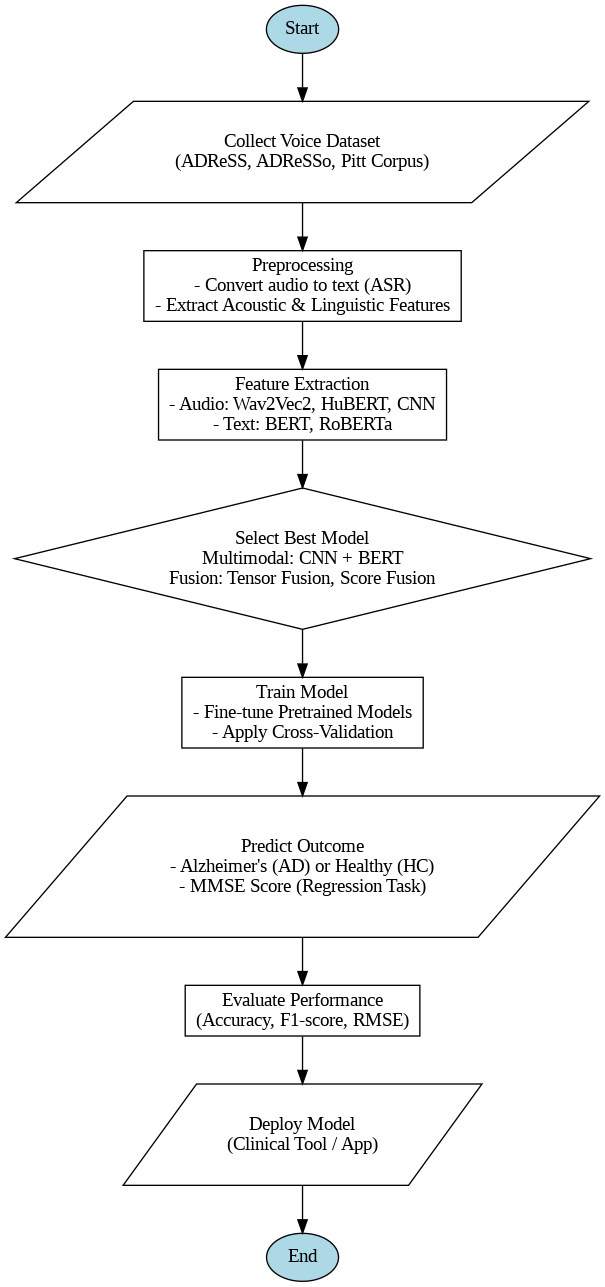

In [5]:
import matplotlib.pyplot as plt

# Display the image using IPython.display.Image
from IPython.display import Image
Image('/content/data/alzheimer_prediction_flowchart.png')

In [9]:
# Import necessary libraries
import os
import numpy as np
import pandas as pd
import torch
import torch.nn as nn
import torch.optim as optim
from torch.utils.data import Dataset, DataLoader
from sklearn.model_selection import train_test_split, KFold
from sklearn.metrics import accuracy_score, f1_score, precision_score, recall_score, mean_squared_error
from sklearn.preprocessing import StandardScaler
import librosa
import matplotlib.pyplot as plt
import transformers
from transformers import Wav2Vec2Processor, Wav2Vec2Model, AutoProcessor, AutoModel
from transformers import BertTokenizer, BertModel, WhisperProcessor, WhisperForConditionalGeneration
import torchaudio
import warnings
warnings.filterwarnings('ignore')

# Set random seeds for reproducibility
torch.manual_seed(42)
np.random.seed(42)

# Step 1: Data Loading and Organization
class AlzheimersDataset(Dataset):
    def __init__(self, audio_paths, transcripts=None, labels=None, mmse_scores=None,
                 audio_processor=None, text_tokenizer=None, max_length=128):
        self.audio_paths = audio_paths
        self.transcripts = transcripts
        self.labels = labels  # Binary labels (0: HC, 1: AD)
        self.mmse_scores = mmse_scores
        self.audio_processor = audio_processor
        self.text_tokenizer = text_tokenizer
        self.max_length = max_length

    def __len__(self):
        return len(self.audio_paths)

    def __getitem__(self, idx):
        # Load and process audio
        audio_path = self.audio_paths[idx]
        waveform, sample_rate = librosa.load(audio_path, sr=16000)

        # Process audio with Wav2Vec2
        if self.audio_processor:
            audio_features = self.audio_processor(
                waveform,
                sampling_rate=16000,
                return_tensors="pt"
            ).input_values.squeeze()
        else:
            # Fallback to raw waveform if no processor
            audio_features = torch.tensor(waveform)

        # Process text if available
        if self.transcripts is not None and self.text_tokenizer is not None:
            text = self.transcripts[idx]
            encodings = self.text_tokenizer(
                text,
                max_length=self.max_length,
                padding="max_length",
                truncation=True,
                return_tensors="pt"
            )
            text_features = {
                'input_ids': encodings['input_ids'].squeeze(),
                'attention_mask': encodings['attention_mask'].squeeze()
            }
        else:
            text_features = None

        # Prepare output based on available data
        output = {'audio': audio_features}

        if text_features is not None:
            output['text'] = text_features

        if self.labels is not None:
            output['label'] = torch.tensor(self.labels[idx], dtype=torch.long)

        if self.mmse_scores is not None:
            output['mmse'] = torch.tensor(self.mmse_scores[idx], dtype=torch.float)

        return output

# Step 2: Speech Preprocessing Functions
def extract_mfcc(audio_path, n_mfcc=13):
    """Extract MFCC features from audio file"""
    waveform, sample_rate = librosa.load(audio_path, sr=16000)
    mfccs = librosa.feature.mfcc(y=waveform, sr=sample_rate, n_mfcc=n_mfcc)
    return mfccs

def extract_prosodic_features(audio_path):
    """Extract prosodic features (pitch, intensity, rhythm)"""
    waveform, sample_rate = librosa.load(audio_path, sr=16000)

    # Pitch (F0) using harmonic component
    pitches, magnitudes = librosa.piptrack(y=waveform, sr=sample_rate)
    pitch = np.mean(pitches[pitches > 0]) if np.any(pitches > 0) else 0

    # Intensity (RMS energy)
    intensity = np.mean(librosa.feature.rms(y=waveform))

    # Rhythm (tempo)
    onset_env = librosa.onset.onset_strength(y=waveform, sr=sample_rate)
    tempo = librosa.beat.tempo(onset_envelope=onset_env, sr=sample_rate)[0]

    return np.array([pitch, intensity, tempo])

def create_spectrogram(audio_path, n_mels=128):
    """Create mel-spectrogram from audio file"""
    waveform, sample_rate = librosa.load(audio_path, sr=16000)
    spectrogram = librosa.feature.melspectrogram(y=waveform, sr=sample_rate, n_mels=n_mels)
    spectrogram_db = librosa.power_to_db(spectrogram, ref=np.max)
    return spectrogram_db

# Step 3: Speech-to-Text Transcription using Whisper
def transcribe_audio(audio_path, whisper_processor, whisper_model):
    """Transcribe audio to text using Whisper"""
    waveform, sample_rate = librosa.load(audio_path, sr=16000)
    input_features = whisper_processor(waveform, sampling_rate=16000, return_tensors="pt").input_features

    # Generate token ids
    predicted_ids = whisper_model.generate(input_features)

    # Decode token ids to text
    transcription = whisper_processor.batch_decode(predicted_ids, skip_special_tokens=True)[0]
    return transcription

# Step 4: Text Preprocessing Functions
def clean_transcript(text):
    """Clean transcript by removing filler words, etc."""
    # Convert to lowercase
    text = text.lower()

    # Remove common filler words
    filler_words = ["um", "uh", "er", "ah", "like", "you know"]
    for word in filler_words:
        text = text.replace(" " + word + " ", " ")

    # Remove extra whitespace
    text = " ".join(text.split())

    return text

# Step 5: Multimodal Model Architecture
class AudioEncoder(nn.Module):
    def __init__(self, pretrained_model_name="facebook/wav2vec2-base-960h"):
        super(AudioEncoder, self).__init__()
        self.model = Wav2Vec2Model.from_pretrained(pretrained_model_name)
        self.feature_dim = self.model.config.hidden_size

    def forward(self, input_values):
        outputs = self.model(input_values)
        # Use mean pooling to get a fixed-size representation
        return torch.mean(outputs.last_hidden_state, dim=1)

class TextEncoder(nn.Module):
    def __init__(self, pretrained_model_name="bert-base-uncased"):
        super(TextEncoder, self).__init__()
        self.model = BertModel.from_pretrained(pretrained_model_name)
        self.feature_dim = self.model.config.hidden_size

    def forward(self, input_ids, attention_mask):
        outputs = self.model(input_ids=input_ids, attention_mask=attention_mask)
        # Use [CLS] token for sentence representation
        return outputs.pooler_output

class MultimodalFusion(nn.Module):
    def __init__(self, audio_dim, text_dim, fusion_output_dim, fusion_type="concat"):
        super(MultimodalFusion, self).__init__()
        self.fusion_type = fusion_type

        if fusion_type == "concat":
            self.output_dim = audio_dim + text_dim
            self.projection = nn.Linear(self.output_dim, fusion_output_dim)
        elif fusion_type == "tensor":
            # Simplified tensor fusion (without bias terms)
            self.output_dim = audio_dim * text_dim
            self.projection = nn.Linear(self.output_dim, fusion_output_dim)
        else:  # Default to add fusion
            assert audio_dim == text_dim, "Dimensions must match for add fusion"
            self.output_dim = audio_dim
            self.projection = nn.Linear(self.output_dim, fusion_output_dim)

    def forward(self, audio_features, text_features):
        if self.fusion_type == "concat":
            fused = torch.cat([audio_features, text_features], dim=1)
        elif self.fusion_type == "tensor":
            # Simplified tensor fusion implementation
            batch_size = audio_features.size(0)
            fused = torch.bmm(
                audio_features.unsqueeze(2),
                text_features.unsqueeze(1)
            ).view(batch_size, -1)
        else:  # add fusion
            fused = audio_features + text_features

        return self.projection(fused)

class AlzheimersDetectionModel(nn.Module):
    def __init__(self, audio_encoder, text_encoder, fusion_output_dim=256, fusion_type="concat"):
        super(AlzheimersDetectionModel, self).__init__()
        self.audio_encoder = audio_encoder
        self.text_encoder = text_encoder

        self.fusion = MultimodalFusion(
            audio_dim=audio_encoder.feature_dim,
            text_dim=text_encoder.feature_dim,
            fusion_output_dim=fusion_output_dim,
            fusion_type=fusion_type
        )

        # Classification head
        self.classifier = nn.Linear(fusion_output_dim, 1)

        # Regression head for MMSE score prediction
        self.regressor = nn.Linear(fusion_output_dim, 1)

    def forward(self, audio_inputs, text_input_ids, text_attention_mask):
        # Get audio features
        audio_features = self.audio_encoder(audio_inputs)

        # Get text features
        text_features = self.text_encoder(text_input_ids, text_attention_mask)

        # Fuse modalities
        fused_features = self.fusion(audio_features, text_features)

        # Classification prediction (sigmoid applied in loss function)
        class_output = self.classifier(fused_features)

        # Regression prediction
        reg_output = self.regressor(fused_features)

        return class_output.squeeze(), reg_output.squeeze()

# Step 6: Training Functions
def train_model(model, train_loader, val_loader, num_epochs=10, learning_rate=1e-4, device='cuda'):
    """Train the multimodal model"""
    model = model.to(device)

    # Define loss functions
    classification_criterion = nn.BCEWithLogitsLoss()
    regression_criterion = nn.MSELoss()

    # Define optimizer
    optimizer = optim.Adam(model.parameters(), lr=learning_rate)

    # Training loop
    best_val_f1 = 0
    best_model_state = None

    for epoch in range(num_epochs):
        model.train()
        train_loss = 0.0

        for batch in train_loader:
            # Move data to device
            audio = batch['audio'].to(device)
            input_ids = batch['text']['input_ids'].to(device)
            attention_mask = batch['text']['attention_mask'].to(device)
            labels = batch['label'].float().to(device)
            mmse = batch['mmse'].to(device)

            # Forward pass
            class_outputs, reg_outputs = model(audio, input_ids, attention_mask)

            # Calculate losses
            class_loss = classification_criterion(class_outputs, labels)
            reg_loss = regression_criterion(reg_outputs, mmse)

            # Combine losses (weighted sum)
            combined_loss = 0.7 * class_loss + 0.3 * reg_loss

            # Backward pass and optimize
            optimizer.zero_grad()
            combined_loss.backward()
            optimizer.step()

            train_loss += combined_loss.item()

        # Validation
        val_metrics = evaluate_model(model, val_loader, device)
        val_f1 = val_metrics['f1']

        print(f"Epoch {epoch+1}/{num_epochs}, Train Loss: {train_loss/len(train_loader):.4f}, "
              f"Val F1: {val_f1:.4f}, Val RMSE: {val_metrics['rmse']:.4f}")

        # Save best model
        if val_f1 > best_val_f1:
            best_val_f1 = val_f1
            best_model_state = model.state_dict().copy()

    # Load best model
    if best_model_state:
        model.load_state_dict(best_model_state)

    return model

def evaluate_model(model, data_loader, device):
    """Evaluate the model and return metrics"""
    model.eval()
    all_labels = []
    all_class_preds = []
    all_mmse_true = []
    all_mmse_preds = []

    with torch.no_grad():
        for batch in data_loader:
            # Move data to device
            audio = batch['audio'].to(device)
            input_ids = batch['text']['input_ids'].to(device)
            attention_mask = batch['text']['attention_mask'].to(device)

            # Forward pass
            class_outputs, reg_outputs = model(audio, input_ids, attention_mask)

            # Apply sigmoid to get probabilities
            class_probs = torch.sigmoid(class_outputs)

            # Convert probabilities to binary predictions
            class_preds = (class_probs > 0.5).int()

            # Collect predictions and ground truth
            all_labels.extend(batch['label'].cpu().numpy())
            all_class_preds.extend(class_preds.cpu().numpy())
            all_mmse_true.extend(batch['mmse'].cpu().numpy())
            all_mmse_preds.extend(reg_outputs.cpu().numpy())

    # Calculate metrics
    accuracy = accuracy_score(all_labels, all_class_preds)
    precision = precision_score(all_labels, all_class_preds, zero_division=0)
    recall = recall_score(all_labels, all_class_preds, zero_division=0)
    f1 = f1_score(all_labels, all_class_preds, zero_division=0)
    rmse = np.sqrt(mean_squared_error(all_mmse_true, all_mmse_preds))

    return {
        'accuracy': accuracy,
        'precision': precision,
        'recall': recall,
        'f1': f1,
        'rmse': rmse
    }

# Step 7: Cross-Validation Function
def cross_validate(dataset, model_class, n_splits=5, batch_size=8, num_epochs=5, device='cuda'):
    """Perform k-fold cross-validation"""
    kf = KFold(n_splits=n_splits, shuffle=True, random_state=42)
    fold_results = []

    # Create index splits
    indices = np.arange(len(dataset))

    for fold, (train_idx, val_idx) in enumerate(kf.split(indices)):
        print(f"Fold {fold+1}/{n_splits}")

        # Create data loaders for this fold
        train_sampler = torch.utils.data.SubsetRandomSampler(train_idx)
        val_sampler = torch.utils.data.SubsetRandomSampler(val_idx)

        train_loader = DataLoader(dataset, batch_size=batch_size, sampler=train_sampler)
        val_loader = DataLoader(dataset, batch_size=batch_size, sampler=val_sampler)

        # Initialize model
        audio_encoder = AudioEncoder()
        text_encoder = TextEncoder()
        model = model_class(audio_encoder, text_encoder)

        # Train the model
        model = train_model(
            model,
            train_loader,
            val_loader,
            num_epochs=num_epochs,
            device=device
        )

        # Evaluate on validation set
        val_metrics = evaluate_model(model, val_loader, device)
        fold_results.append(val_metrics)

        print(f"Fold {fold+1} Results: F1={val_metrics['f1']:.4f}, RMSE={val_metrics['rmse']:.4f}")

    # Calculate average metrics across folds
    avg_metrics = {
        metric: np.mean([fold[metric] for fold in fold_results])
        for metric in fold_results[0].keys()
    }

    print("\nCross-Validation Results:")
    print(f"Avg Accuracy: {avg_metrics['accuracy']:.4f}")
    print(f"Avg F1 Score: {avg_metrics['f1']:.4f}")
    print(f"Avg RMSE: {avg_metrics['rmse']:.4f}")

    return fold_results, avg_metrics

# Step 8: Main Pipeline
def main(data_dir, output_dir, use_cross_validation=True):
    # Create output directory if it doesn't exist
    os.makedirs(output_dir, exist_ok=True)

    # Step 1: Load and preprocess data
    print("Loading data...")

    # Load audio paths, transcripts, labels, and MMSE scores from CSV
    # This is a placeholder for your specific data loading logic
    data_df = pd.read_csv(os.path.join(data_dir, 'metadata.csv'))

    # Adjust paths to be relative to data_dir
    audio_paths = [os.path.join(data_dir, path) for path in data_df['audio_path']]
    transcripts = data_df['transcript'].tolist()
    labels = data_df['label'].tolist()  # 0 for HC, 1 for AD
    mmse_scores = data_df['mmse_score'].tolist()

    # Step 2: Initialize processors
    print("Loading pretrained models...")

    # Load Whisper for speech transcription
    whisper_processor = WhisperProcessor.from_pretrained("openai/whisper-small")
    whisper_model = WhisperForConditionalGeneration.from_pretrained("openai/whisper-small")

    # Load Wav2Vec2 for audio processing
    audio_processor = Wav2Vec2Processor.from_pretrained("facebook/wav2vec2-base-960h")

    # Load BERT tokenizer for text processing
    text_tokenizer = BertTokenizer.from_pretrained("bert-base-uncased")

    # Step 3: Transcribe audio files if transcripts are not available
    if transcripts is None or len(transcripts) == 0:
        print("Transcribing audio files...")
        transcripts = []
        for audio_path in audio_paths:
            transcript = transcribe_audio(audio_path, whisper_processor, whisper_model)
            transcripts.append(clean_transcript(transcript))

    # Step 4: Create dataset
    dataset = AlzheimersDataset(
        audio_paths=audio_paths,
        transcripts=transcripts,
        labels=labels,
        mmse_scores=mmse_scores,
        audio_processor=audio_processor,
        text_tokenizer=text_tokenizer
    )

    # Step 5: Set device
    device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
    print(f"Using device: {device}")

    # Step 6: Split data or use cross-validation
    if use_cross_validation:
        print("Performing cross-validation...")
        fold_results, avg_metrics = cross_validate(
            dataset=dataset,
            model_class=AlzheimersDetectionModel,
            device=device
        )

        # Save cross-validation results
        with open(os.path.join(output_dir, 'cv_results.txt'), 'w') as f:
            f.write(f"Cross-Validation Results:\n")
            f.write(f"Avg Accuracy: {avg_metrics['accuracy']:.4f}\n")
            f.write(f"Avg F1 Score: {avg_metrics['f1']:.4f}\n")
            f.write(f"Avg RMSE: {avg_metrics['rmse']:.4f}\n")
    else:
        # Split data into train, validation, and test sets
        train_idx, test_idx = train_test_split(
            np.arange(len(dataset)),
            test_size=0.2,
            random_state=42,
            stratify=labels
        )

        train_idx, val_idx = train_test_split(
            train_idx,
            test_size=0.25,  # 0.25 * 0.8 = 0.2 of total
            random_state=42,
            stratify=[labels[i] for i in train_idx]
        )

        # Create data loaders
        train_sampler = torch.utils.data.SubsetRandomSampler(train_idx)
        val_sampler = torch.utils.data.SubsetRandomSampler(val_idx)
        test_sampler = torch.utils.data.SubsetRandomSampler(test_idx)

        train_loader = DataLoader(dataset, batch_size=8, sampler=train_sampler)
        val_loader = DataLoader(dataset, batch_size=8, sampler=val_sampler)
        test_loader = DataLoader(dataset, batch_size=8, sampler=test_sampler)

        # Initialize and train model
        print("Training model...")
        audio_encoder = AudioEncoder()
        text_encoder = TextEncoder()
        model = AlzheimersDetectionModel(audio_encoder, text_encoder)

        model = train_model(
            model,
            train_loader,
            val_loader,
            num_epochs=10,
            device=device
        )

        # Evaluate on test set
        print("Evaluating model...")
        test_metrics = evaluate_model(model, test_loader, device)

        print("Test Results:")
        print(f"Accuracy: {test_metrics['accuracy']:.4f}")
        print(f"F1 Score: {test_metrics['f1']:.4f}")
        print(f"RMSE: {test_metrics['rmse']:.4f}")

        # Save model
        torch.save(model.state_dict(), os.path.join(output_dir, 'model.pt'))

        # Save test results
        with open(os.path.join(output_dir, 'test_results.txt'), 'w') as f:
            f.write(f"Test Results:\n")
            f.write(f"Accuracy: {test_metrics['accuracy']:.4f}\n")
            f.write(f"Precision: {test_metrics['precision']:.4f}\n")
            f.write(f"Recall: {test_metrics['recall']:.4f}\n")
            f.write(f"F1 Score: {test_metrics['f1']:.4f}\n")
            f.write(f"RMSE: {test_metrics['rmse']:.4f}\n")

    print("Done!")

# Step 9: Model Deployment Functions
def create_web_app(model_path, audio_processor, text_tokenizer, device):
    """Create a Flask web app for model deployment"""
    from flask import Flask, request, jsonify

    app = Flask(__name__)

    # Load model
    audio_encoder = AudioEncoder()
    text_encoder = TextEncoder()
    model = AlzheimersDetectionModel(audio_encoder, text_encoder)
    model.load_state_dict(torch.load(model_path))
    model = model.to(device)
    model.eval()

    @app.route('/predict', methods=['POST'])
    def predict():
        # Get audio file from request
        audio_file = request.files.get('audio')

        if not audio_file:
            return jsonify({'error': 'No audio file provided'}), 400

        # Save audio file temporarily
        temp_path = 'temp_audio.wav'
        audio_file.save(temp_path)

        # Transcribe audio
        waveform, sample_rate = librosa.load(temp_path, sr=16000)
        input_features = whisper_processor(waveform, sampling_rate=16000, return_tensors="pt").input_features
        predicted_ids = whisper_model.generate(input_features)
        transcript = whisper_processor.batch_decode(predicted_ids, skip_special_tokens=True)[0]
        transcript = clean_transcript(transcript)

        # Process audio for model input
        audio_input = audio_processor(
            waveform,
            sampling_rate=16000,
            return_tensors="pt"
        ).input_values.squeeze().unsqueeze(0).to(device)

        # Process text for model input
        text_encodings = text_tokenizer(
            transcript,
            max_length=128,
            padding="max_length",
            truncation=True,
            return_tensors="pt"
        )

        input_ids = text_encodings['input_ids'].to(device)
        attention_mask = text_encodings['attention_mask'].to(device)

        # Make prediction
        with torch.no_grad():
            class_output, reg_output = model(audio_input, input_ids, attention_mask)

            # Convert to probabilities and binary prediction
            class_prob = torch.sigmoid(class_output).item()
            class_pred = 1 if class_prob > 0.5 else 0
            mmse_pred = reg_output.item()

        # Clean up
        os.remove(temp_path)

        # Return prediction
        return jsonify({
            'prediction': 'AD' if class_pred == 1 else 'HC',
            'probability': class_prob,
            'mmse_prediction': mmse_pred,
            'transcript': transcript
        })

    return app

# Example of how to run the main pipeline
if __name__ == "__main__":
    # Configure paths
    data_dir = "path/to/your/data"
    output_dir = "path/to/output"

    # Run the main pipeline
    main(data_dir, output_dir, use_cross_validation=True)


Loading data...


FileNotFoundError: [Errno 2] No such file or directory: 'path/to/your/data/metadata.csv'